In [1]:
import os 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report 
import joblib
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [2]:



data_dir = '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer'
target_folders = ['ALL','Brain Cancer','Breast Cancer','Cervical Cancer','Kidney Cancer','Lung and Colon Cancer','Lymphoma','Oral Cancer']  # List of folders

filepath = []
labels = []

for target_folder in target_folders:  # Iterate over each folder
    all_folder_path = os.path.join(data_dir, target_folder)

    # Check if folder exists
    if not os.path.isdir(all_folder_path):
        print(f" Warning: Folder '{all_folder_path}' does not exist.")
        continue  # Skip this folder

    print(f" Processing folder: {all_folder_path}")

    # Loop through subdirectories (e.g., cancer subtypes)
    filelist = os.listdir(all_folder_path)
    for f in filelist:
        fpath = os.path.join(all_folder_path, f)

        if not os.path.isdir(fpath):  # Ensure it's a folder
            print(f"Skipping non-folder: {fpath}")
            continue

        fipath = os.listdir(fpath)
        print(f"Found {len(fipath)} images in '{target_folder}/{f}'")

        for image in fipath:
            if image.lower().endswith(('.png', '.jpg', '.jpeg')):  # Only add images
                path = os.path.join(fpath, image)
                filepath.append(path)
                labels.append(f"{target_folder}/{f}")  # Label includes cancer type

# Create DataFrame
df = pd.DataFrame({'filepath': filepath, 'labels': labels})
print(df.head())  # Show first few rows
print(" Total images found:", df.shape[0])



 Processing folder: /kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/ALL
Found 5000 images in 'ALL/all_pro'
Found 5000 images in 'ALL/all_benign'
Found 5000 images in 'ALL/all_early'
Found 5000 images in 'ALL/all_pre'
 Processing folder: /kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Brain Cancer
Found 5000 images in 'Brain Cancer/brain_tumor'
Found 5000 images in 'Brain Cancer/brain_glioma'
Found 5000 images in 'Brain Cancer/brain_menin'
 Processing folder: /kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Breast Cancer
Found 5000 images in 'Breast Cancer/breast_benign'
Found 5000 images in 'Breast Cancer/breast_malignant'
 Processing folder: /kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Cervical Cancer
Found 5000 images in 'Cervical Cancer/cervix_koc'
Found 5000 images in 'Cervical Cancer/cervix_dyk'
Found 5000 images in 'Cervical Cancer/cervix_pab'
Found 5000 images in 'Cervical Cancer/cervix_sfi'
Found 5000 images in 'Cervical Cancer/cervix_mep'
 Processing fold

In [3]:
df

,filepath,labels
0,/kaggle/input/multi-cancer/Multi Cancer/Multi ...,ALL/all_pro
1,/kaggle/input/multi-cancer/Multi Cancer/Multi ...,ALL/all_pro
2,/kaggle/input/multi-cancer/Multi Cancer/Multi ...,ALL/all_pro
3,/kaggle/input/multi-cancer/Multi Cancer/Multi ...,ALL/all_pro
4,/kaggle/input/multi-cancer/Multi Cancer/Multi ...,ALL/all_pro
...,...,...
129997,/kaggle/input/multi-cancer/Multi Cancer/Multi ...,Oral Cancer/oral_normal
129998,/kaggle/input/multi-cancer/Multi Cancer/Multi ...,Oral Cancer/oral_normal
129999,/kaggle/input/multi-cancer/Multi Cancer/Multi ...,Oral Cancer/oral_normal
130000,/kaggle/input/multi-cancer/Multi Cancer/Multi ...,Oral Cancer/oral_normal


In [4]:
count=df['labels'].value_counts().reset_index()
count.columns=['labels','count']
count_fig=px.bar(count,x='labels',y='count',title='count of labels',text_auto=True)
count_fig.show()

In [5]:
strat=df['labels']
train_df ,dummy_df=train_test_split(df,test_size=0.3,random_state=42,stratify=strat)
strate=dummy_df['labels']
valid_df,test_df=train_test_split(dummy_df,test_size=0.5,random_state=42,stratify=strate)

In [6]:
print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

(91001, 2)
(19500, 2)
(19501, 2)


In [7]:
count_train=train_df['labels'].value_counts().reset_index()
count_train.columns=['labels','count']
count=px.bar(count_train,x='labels',y='count',title='count of labels per train_df',text_auto=True)
count.show()

In [8]:
count_valid=valid_df['labels'].value_counts().reset_index()
count_valid.columns=['labels','count']
fig=px.bar(count_valid,x='labels',y='count',title='count of labels per valid_df',text_auto=True)
fig.show()

In [9]:
count_test=test_df['labels'].value_counts().reset_index()
count_test.columns=['labels','count']
fig=px.bar(count_test,x='labels',y='count',title='count of labels per test_df',text_auto=True)
fig.show()

In [20]:
batch_size = 64
img_size = (224,224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
tr_gen = ImageDataGenerator(
    rotation_range=40,        
    width_shift_range=0.2,    
    height_shift_range=0.2,   
    horizontal_flip=True,     
    fill_mode='nearest' )      
ts_gen=ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe(train_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 91001 validated image filenames belonging to 26 classes.
Found 19500 validated image filenames belonging to 26 classes.
Found 19501 validated image filenames belonging to 26 classes.


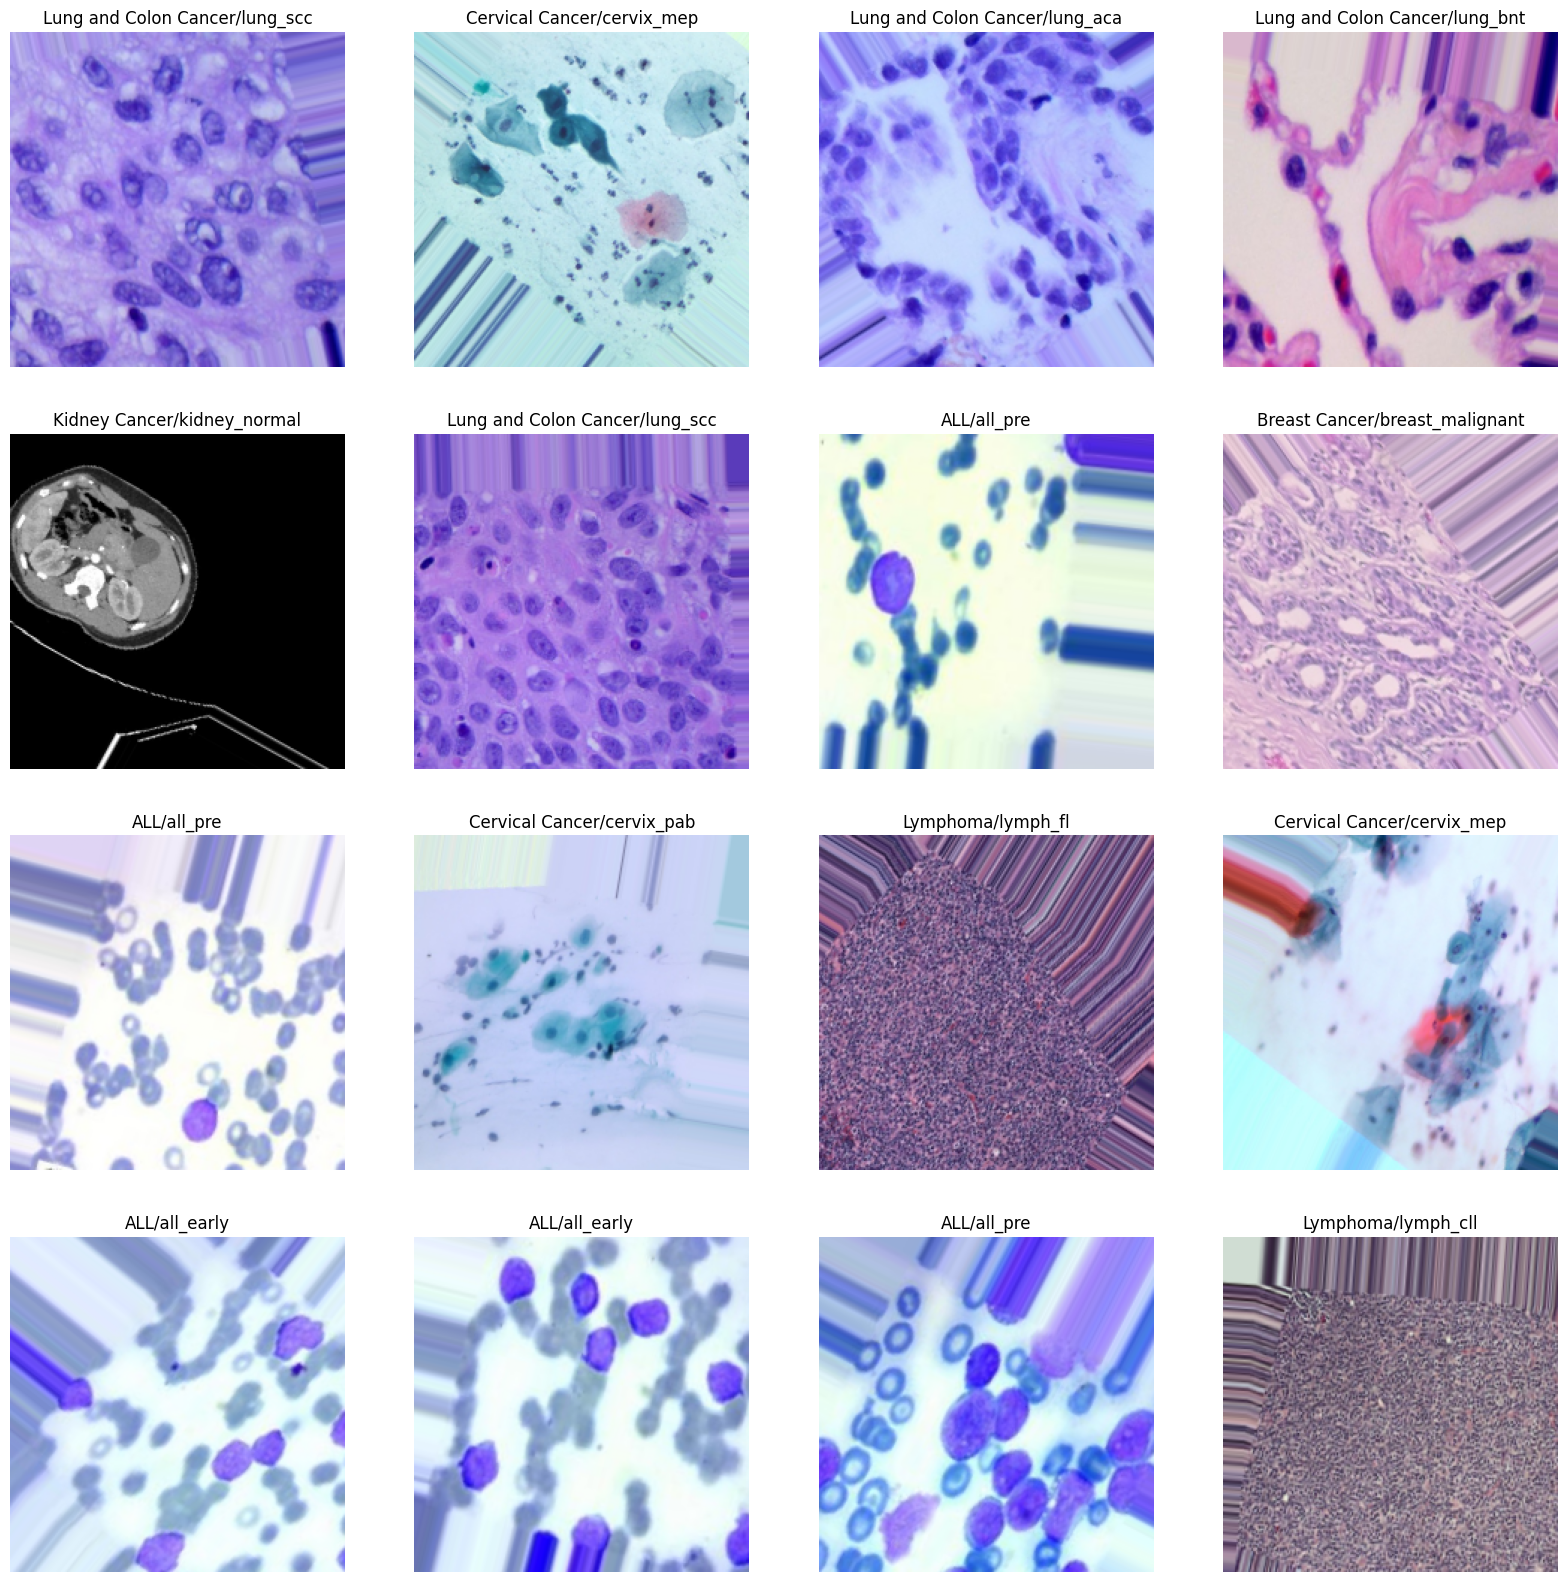

In [22]:
g_dict = train_gen.class_indices    
classes = list(g_dict.keys())      
images, labels = next(train_gen)     
plt.figure(figsize= (20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255      
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'black', fontsize= 12)
    plt.axis('off')
plt.show()

In [23]:
weights_path = "/kaggle/input/efficientnet/tensorflow2/default/1/efficientnetb0_notop.h5"
base_model=keras.applications.EfficientNetB0(include_top=False,
    weights=weights_path,
    input_shape=(224,224,3))
model=Sequential([
    base_model,
    Flatten(),
    Dense(256,activation='relu'),
    Dropout(0.25),
    Dense(128,activation='relu'),
    Dense(3,activation='softmax')
])
model.compile(Adamax(learning_rate= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [24]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │      16,056,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,139,430 (76.83 MB)

 Trainable params: 20,097,407 (76.67 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [25]:
num_classes = len(train_gen.class_indices)  # This should be 17 in your case
print(f" Number of classes in dataset: {num_classes}")


 Number of classes in dataset: 26


In [26]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0

# Assuming EfficientNetB0 as the base model
base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights=weights_path)

# Create your final model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')  
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [29]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [30]:
# ✅ Early stopping to avoid overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# ✅ Save the best model during training
checkpoint = ModelCheckpoint(
    "best_cancer_model.keras",
    monitor='val_loss',
    save_best_only=True
)

# ✅ Train the model
history = model.fit(
    train_gen,
    epochs=100,
    validation_data=valid_gen,
    shuffle=False,
    verbose=1,  # Keeps printing batch info to avoid idle timeout
    callbacks=[early_stopping, checkpoint]
)

# ✅ Save final model (in case it differs from the best one)
model.save("cancer_main_model_efficientnetB0.keras")

# ✅ Optional: Save training history for later plotting
import json
with open("training_history.json", "w") as f:
    json.dump(history.history, f)

Epoch 1/100
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 2038s 1s/step - accuracy: 0.9147 - loss: 0.2420 - val_accuracy: 0.9227 - val_loss: 0.2835
Epoch 2/100
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 1304s 917ms/step - accuracy: 0.9623 - loss: 0.1103 - val_accuracy: 0.9725 - val_loss: 0.0850
Epoch 3/100
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 1312s 923ms/step - accuracy: 0.9733 - loss: 0.0801 - val_accuracy: 0.9510 - val_loss: 0.1665
Epoch 4/100
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 1307s 919ms/step - accuracy: 0.9760 - loss: 0.0760 - val_accuracy: 0.9729 - val_loss: 0.0789
Epoch 5/100
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 1298s 913ms/step - accuracy: 0.9827 - loss: 0.0539 - val_accuracy: 0.9728 - val_loss: 0.0832
Epoch 6/100
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 1311s 922ms/step - accuracy: 0.9824 - loss: 0.0536 - val_accuracy: 0.9880 - val_loss: 0.0325
Epoch 7/100
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 1273s 895ms/step - accuracy: 0.9841 - loss: 0.0484 - val_accuracy: 0.9878 - val_loss: 0.0411
Epoch 8/100
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 1308s 92

In [31]:
import os
os.listdir()
for root, dirs, files in os.walk("/kaggle/working"):
    for file in files:
        print(os.path.join(root, file))


['best_cancer_model.keras',
 '.virtual_documents',
 'cancer_main_model_efficientnetB0.keras',
 'training_history.json']